In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Packages and Data

In [2]:
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install --upgrade protobuf
# pip install -q git+https://github.com/MJAHMADEE/docs

In [5]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


In [6]:
# !pip uninstall tensorflow -y
!pip uninstall tensorflow-io -y
# !pip install tensorflow
!pip install --no-deps tensorflow-io

Found existing installation: tensorflow-io 0.31.0
Uninstalling tensorflow-io-0.31.0:
  Successfully uninstalled tensorflow-io-0.31.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 48.6 MB/s eta 0:00:0000:0100:01


In [7]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [8]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [9]:
# !pip uninstall protobuf -y

# !pip install protobuf==4.21

# Overview
In this notebook, I will create Video Classfication Models using 2 kinds of architectures:
Conv3D
EfficientNet

I wil use UCF101 dataset as training dataset. There are 13320 videos that contains 101 kinds of action. Because of limited resources, I will only choose videos of first 41 kinds of actions for training.

In [10]:
import os
import tensorflow as tf
import imageio
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm.notebook import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import cv2
import random
import glob

from tensorflow_docs.vis import embed


In [11]:
from ipywidgets import FloatProgress

In [12]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt

In [14]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [15]:
len(label_data)

101

# Helper Functions

In [16]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size = (64,64), frame_step = 20):
  
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=10)
    return embed.embed_file('./animation.gif')

# Import dataset

In [17]:
epoches = 10
batch_size=32
file_paths = []
targets = []
i=0
for a in label_data['labels'].unique()[:41]:
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{a}/**.avi")
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)
    i+=1

In [18]:
print(len(file_paths))

5488


In [19]:
# print(file_paths)

In [20]:
print (label_data['labels'].unique()[:41])


['ApplyEyeMakeup' 'ApplyLipstick' 'Archery' 'BabyCrawling' 'BalanceBeam'
 'BandMarching' 'BaseballPitch' 'Basketball' 'BasketballDunk' 'BenchPress'
 'Biking' 'Billiards' 'BlowDryHair' 'BlowingCandles' 'BodyWeightSquats'
 'Bowling' 'BoxingPunchingBag' 'BoxingSpeedBag' 'BreastStroke'
 'BrushingTeeth' 'CleanAndJerk' 'CliffDiving' 'CricketBowling'
 'CricketShot' 'CuttingInKitchen' 'Diving' 'Drumming' 'Fencing'
 'FieldHockeyPenalty' 'FloorGymnastics' 'FrisbeeCatch' 'FrontCrawl'
 'GolfSwing' 'Haircut' 'Hammering' 'HammerThrow' 'HandstandPushups'
 'HandstandWalking' 'HeadMassage' 'HighJump' 'HorseRace']


# Sample Video

(10, 64, 64, 3)



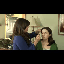

In [21]:
sample_video = frames_from_video_file(file_paths[0], n_frames = 10)
print(sample_video.shape)
to_gif(sample_video)

# Create Training and Validation dataset

In [22]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 10))
features = np.array(features)

  0%|          | 0/5488 [00:00<?, ?it/s]

In [23]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
train_features.shape, val_features.shape, len(train_targets), len(val_targets)

((4390, 10, 64, 64, 3), (1098, 10, 64, 64, 3), 4390, 1098)

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(batch_size * 4).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [25]:
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

Delete unused data to release memory

In [26]:
del train_features
del val_features
gc.collect()

182

In [27]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 64, 64, 3) (32,)


# Modeling with Conv3D

In [28]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10, 64, 64, 3)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(label_data['labels'].unique()[:41]), activation="softmax")
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[
        "accuracy"
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 64, 64, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 32, 32, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 16, 16, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 16, 16, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 8, 8, 128)     0

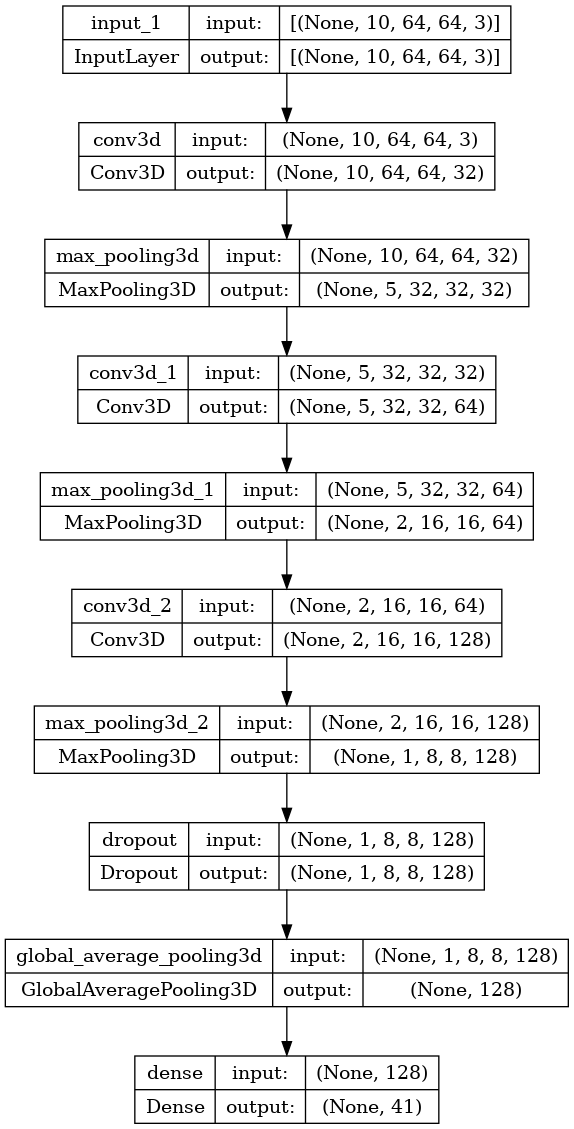

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)
history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=valid_ds, 
    callbacks=[checkpoint]
)
model.load_weights("model.h5")

Epoch 1/30
138/138 [==============================] - 21s 75ms/step - loss: 3.4467 - accuracy: 0.0786 - val_loss: 3.1142 - val_accuracy: 0.1421
Epoch 2/30
138/138 [==============================] - 9s 62ms/step - loss: 2.8654 - accuracy: 0.2121 - val_loss: 2.6948 - val_accuracy: 0.2477
Epoch 3/30
138/138 [==============================] - 9s 63ms/step - loss: 2.4930 - accuracy: 0.3000 - val_loss: 2.4287 - val_accuracy: 0.3179
Epoch 4/30
138/138 [==============================] - 9s 63ms/step - loss: 2.2434 - accuracy: 0.3656 - val_loss: 2.1394 - val_accuracy: 0.3934
Epoch 5/30
138/138 [==============================] - 9s 64ms/step - loss: 2.0317 - accuracy: 0.4105 - val_loss: 1.9994 - val_accuracy: 0.4353
Epoch 6/30
138/138 [==============================] - 9s 63ms/step - loss: 1.8464 - accuracy: 0.4569 - val_loss: 1.9552 - val_accuracy: 0.4490
Epoch 7/30
138/138 [==============================] - 9s 63ms/step - loss: 1.6897 - accuracy: 0.4989 - val_loss: 1.8747 - val_accuracy: 0.468

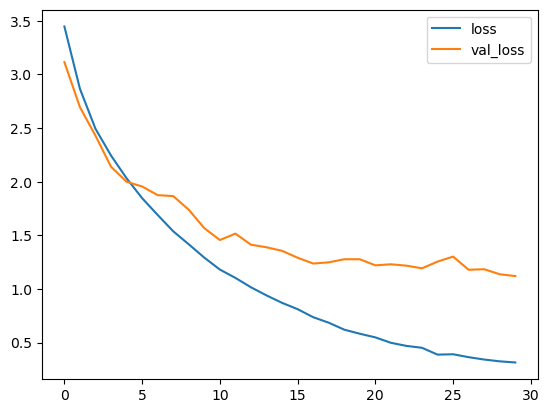

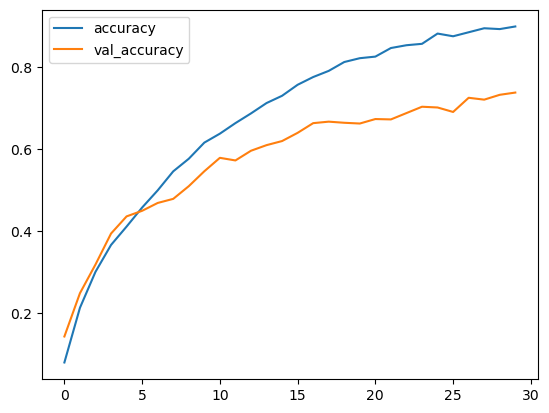

In [31]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [32]:
val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

35/35 [==============================] - 1s 25ms/step - loss: 1.1204 - accuracy: 0.7377
Validation Loss:1.1203619241714478 Validation Accuracy:0.7377049326896667


# Modeling with EfficientNet

In [33]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(len(label_data['labels'].unique()[:41])),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


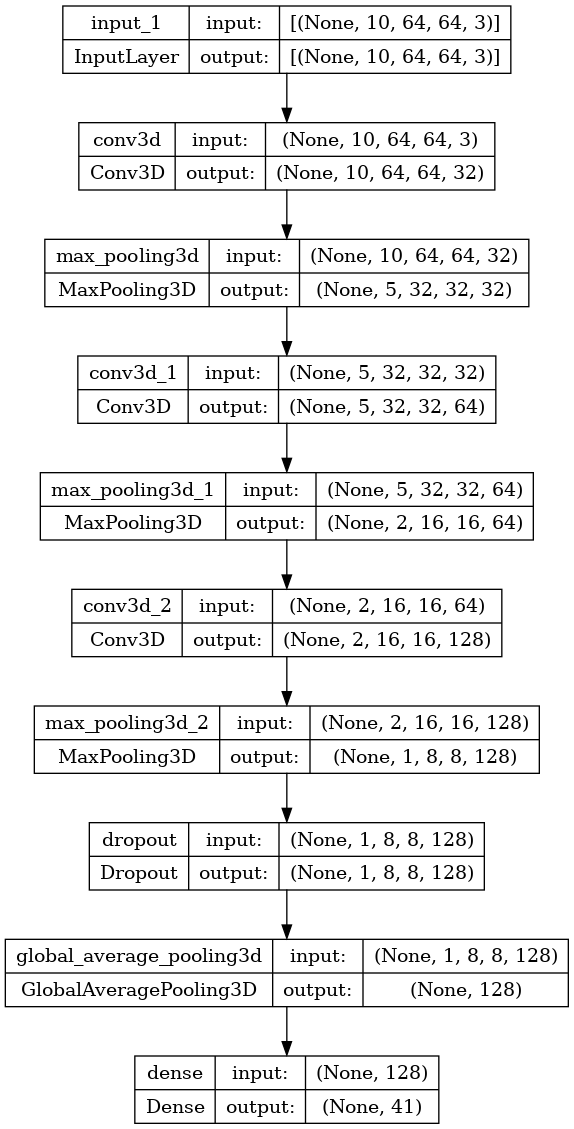

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
history = efficient_net_model.fit(
    train_ds,
    epochs = 10,
    validation_data=valid_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.h5", 
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/10
138/138 [==============================] - 9s 69ms/step - loss: 0.4953 - accuracy: 0.9025 - val_loss: 0.6688 - val_accuracy: 0.8279
Epoch 2/10
138/138 [==============================] - 9s 68ms/step - loss: 0.4560 - accuracy: 0.9141 - val_loss: 0.6393 - val_accuracy: 0.8315
Epoch 3/10
138/138 [==============================] - 9s 68ms/step - loss: 0.4250 - accuracy: 0.9214 - val_loss: 0.6127 - val_accuracy: 0.8379
Epoch 4/10
138/138 [==============================] - 9s 68ms/step - loss: 0.3963 - accuracy: 0.9262 - val_loss: 0.5872 - val_accuracy: 0.8443
Epoch 5/10
138/138 [==============================] - 9s 69ms/step - loss: 0.3665 - accuracy: 0.9351 - val_loss: 0.5651 - val_accuracy: 0.8497
Epoch 6/10
138/138 [==============================] - 9s 68ms/step - loss: 0.3449 - accuracy: 0.9410 - val_loss: 0.5482 - val_accuracy: 0.8534
Epoch 7/10
138/138 [==============================] - 9s 66ms/step - loss: 0.3272 - accuracy: 0.9444 - val_loss: 0.5308 - val_accuracy: 0.8515

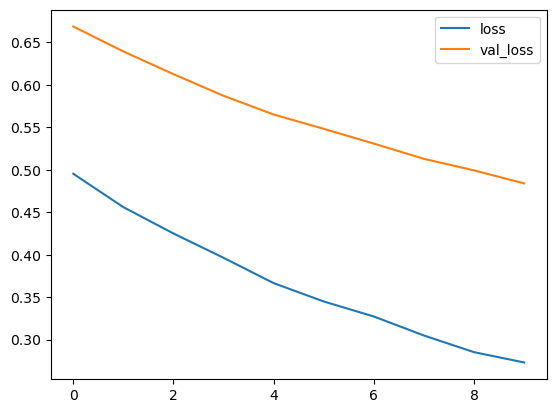

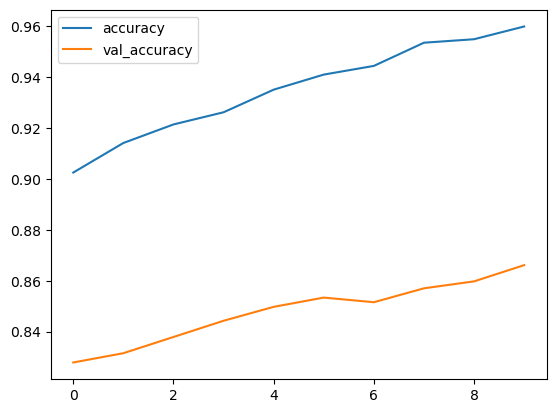

In [40]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [41]:
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

35/35 [==============================] - 2s 58ms/step - loss: 0.4840 - accuracy: 0.8661
Validation Loss:0.48396581411361694 Validation Accuracy:0.8661202192306519


In [42]:
model.save('UCF101_Model.h5')

# Conclusions
In this notebook I create 2 kinds of video classification models, one is Conv3D architecture, another is based on pretrained EfficientNet Model by using a method known as Transfer Learning. Transfer Learning can help boost accuracy of video classification model.